In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# import dataset from seaborn
import seaborn as sns
iris = sns.load_dataset("iris")

In [3]:
# organize the data

# convert from pandas dataframe to tensor
data = torch.tensor(iris[iris.columns[0:4]].values).float()

# transform species to number
labels = torch.zeros(len(data), dtype = torch.long)
# labels[iris.species == "setosa"] = 0 # don't need
labels[iris.species == "versicolor"] = 1
labels[iris.species == "virginica"] = 2

labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2])

In [5]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = .2)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = TensorDataset(train_data, train_labels)
test_dataDataset = TensorDataset(test_data, test_labels)

In [6]:
def createANewModel():
    # model Architecture
    ANNiris = nn.Sequential(
        nn.Linear(4, 64), # input layer
        nn.ReLU(), # activation unit
        nn.Linear(64, 64), # activation unit
        nn.ReLU(), # activation unit
        nn.Linear(64, 3) # output unit
    )

    # loss function
    lossfun = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.SGD(ANNiris.parameters(), lr = .001)

    return ANNiris, lossfun, optimizer

In [7]:
# train the model

# training parameter
numepochs = 500

def trainTheModel():
    trainAcc = []
    testAcc = []
    losses = []
    
    # train the model
    for epochi in range(numepochs):

        # activate training mode
        ANNiris.train()
        
        # loop over training data batches
        batchAcc = []
        batchLoss = []
        for X, y in train_loader:

            # forward pass and loss
            yHat = ANNiris(X)
            loss = lossfun(yHat, y)
            
            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # compute training accuracy just for this batch
            batchAcc.append(100 * torch.mean((torch.argmax(yHat, axis = 1) == y).float()).item())
            batchLoss.append(loss.item())
            
        # now that we've trained through the batches, get avg training accuracy
        trainAcc.append(np.mean(batchAcc))
        losses.append(np.mean(batchLoss))

        # test accuracy
        X, y = next(iter(test_loader))  # extract X, y from test dataloader
        
        # activate testing mode
        ANNiris.eval()
        with torch.no_grad():
            predlabels = torch.argmax(ANNiris(X), axis = 1)

        # compute test accuracy
        testAcc.append(100 * torch.mean((predlabels == y).float()).item())
        
    # function output
    return trainAcc, testAcc, losses

In [9]:
# range of batch sizes
batchsizes = 2**np.arange(1, 7)

# initialize output results matrices
accuracyResultsTrain = np.zeros((numepochs, len(batchsizes)))
accuracyResultsTest = np.zeros((numepochs, len(batchsizes)))

# test data doesn't vary by training batch size
test_loader = DataLoader(test_dataDataset, batch_size = test_dataDataset.tensors[0].shape[0])

# loop over batch sizes
for bi in range(len(batchsizes)):

    # create dataLoader object
    train_loader = DataLoader(train_dataDataset, batch_size = int(batchsizes[bi]), shuffle = True, drop_last = True)

    # create and train a model
    ANNiris, lossfun, optimizer = createANewModel()
    trainAcc, testAcc, losses = trainTheModel()

    # store data
    accuracyResultsTrain[:, bi] = trainAcc
    accuracyResultsTest[:, bi] = testAcc

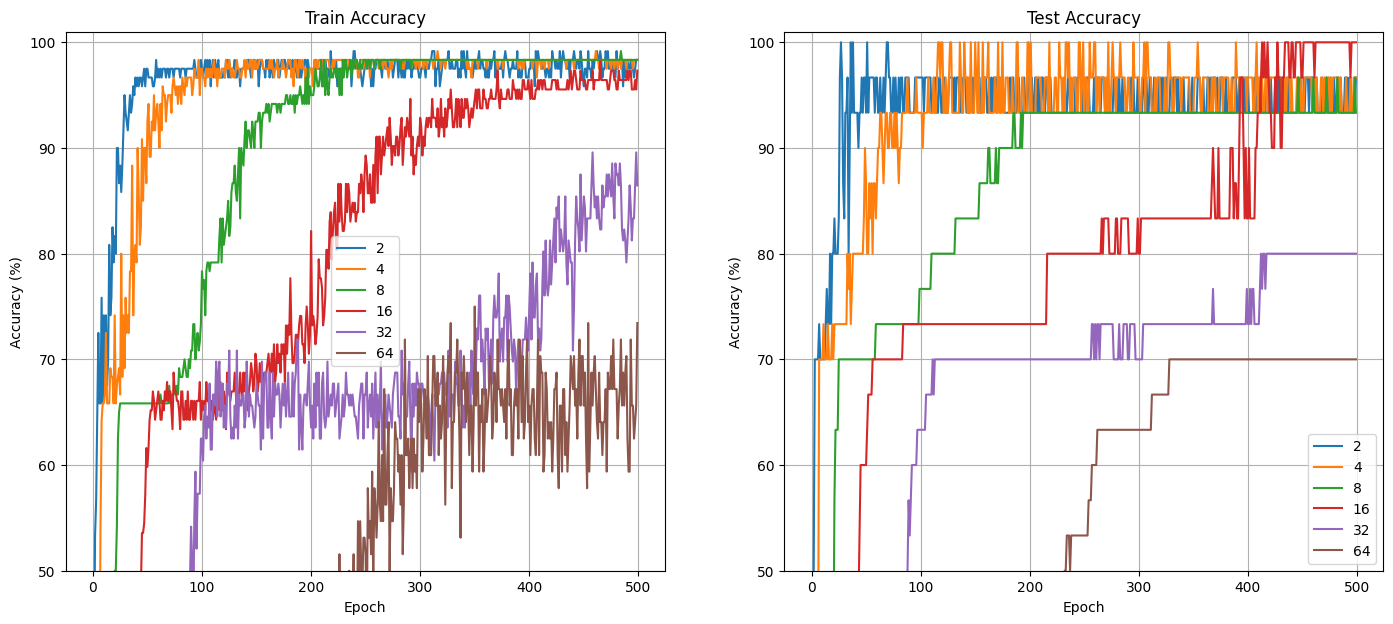

In [11]:
# plot some results
fig, ax = plt.subplots(1, 2, figsize = (17, 7))

ax[0].plot(accuracyResultsTrain)
ax[0].set_title("Train Accuracy")
ax[1].plot(accuracyResultsTest)
ax[1].set_title("Test Accuracy")

# common features
for i in range(2):
    ax[i].legend(batchsizes)
    ax[i].set_xlabel("Epoch")
    ax[i].set_ylabel("Accuracy (%)")
    ax[i].set_ylim([50, 101])
    ax[i].grid()

plt.show()